#### Task (class ‘D’):

    Considering the subset of 19 channels suggested in Figure 1 and Table 2,
    estimate the connectivity using PDC or DTF and apply a statistical validation method
    (asymptotic statistics7, resampling procedure8,...) to filter out values that are not significantly
    different from 0 ( PDC(i, j) <> 0 with p < 5% )

#### Importing the routine libraries

In [37]:
import sys
sys.path.insert(0, '../Lib')
from homeworkLib import EEGGraph
import connectivipy as cp
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import re
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

In [19]:
# creating two objects for our analysis
#   EO -> object representing the data recorded during eyes-opened resting state.
#   EC -> object representing the data recorded during eyes-closed resting state.
EO = EEGGraph("../../Data/S003R01.edf")
EC = EEGGraph("../../Data/S003R02.edf")
#Reading in the channel locations
locations = {re.sub('[^\w]',"",x[1][1]):(x[1]['x'], x[1]['y']) for x in pd.read_csv("../../Data/channel_locations.txt", 
                                                                                    sep = "\s+").iterrows()}

### Let's visualise the EEG data

#### Eyes-opened data: first 5 channels

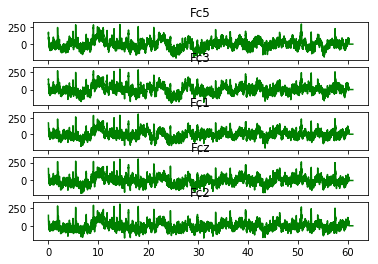

In [20]:
EO.plot_data(nbr_of_channels = 5)

#### Eyes-closed data: first 5 channels

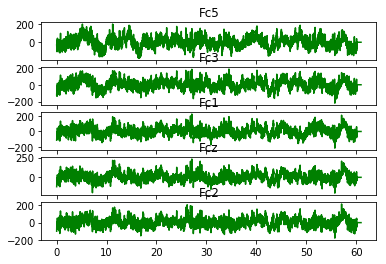

In [21]:
EC.plot_data(nbr_of_channels = 5)

### extracting subset datasets for given nodes

In [22]:
subset_channel_names = "Fp1 Fp2 F7 F3 Fz F4 F8 T7 C3 Cz C4 T8 P7 P3 Pz P4 P8 O1 O2".split()
subset_channel_indexes_open = list(map(lambda x: EO.labels.index(x), subset_channel_names))
subset_channel_indexes_closed = list(map(lambda x: EC.labels.index(x), subset_channel_names))

EO.signals = np.take(EO.signals, subset_channel_indexes_open, axis = 0)
EC.signals = np.take(EC.signals, subset_channel_indexes_closed, axis = 0)
EO.labels = subset_channel_names

### Estimation of the functional brain connectivity on the subset of 19 channels using both DTF and PDC

In [63]:
class ImprovedDTF(cp.conn.DTF):
    def levels(self, signi, alpha, k):
        resolutions = signi.shape[1]
        
        if self.two_sided:
            ficance = np.zeros((resolutions, 2, k, k))
        else:
            ficance = np.zeros((resolutions, k, k))

        for freq in range(resolutions):
            for i in range(k):
                for j in range(k):
                    if self.two_sided:
                        ficance[freq][0][i][j] = st.scoreatpercentile(signi[:, freq, i, j], alpha*100)
                        ficance[freq][1][i][j] = st.scoreatpercentile(signi[:, freq, i, j], (1-alpha)*100)
                    else:
                        ficance[freq][i][j] = st.scoreatpercentile(signi[:, freq, i, j], (1-alpha)*100)
        return ficance
    
class ImprovedPDC(cp.conn.PDC):
    def levels(self, signi, alpha, k):
        resolutions = signi.shape[1]
        
        if self.two_sided:
            ficance = np.zeros((resolutions, 2, k, k))
        else:
            ficance = np.zeros((resolutions, k, k))

        for freq in range(resolutions):
            for i in range(k):
                for j in range(k):
                    if self.two_sided:
                        ficance[freq][0][i][j] = st.scoreatpercentile(signi[:, freq, i, j], alpha*100)
                        ficance[freq][1][i][j] = st.scoreatpercentile(signi[:, freq, i, j], (1-alpha)*100)
                    else:
                        ficance[freq][i][j] = st.scoreatpercentile(signi[:, freq, i, j], (1-alpha)*100)
        return ficance

def get_connectivity_estimates(data, channel_names, order, sampling_frequency = 160, alpha=0.05, Nrep = 100, resolution = 100):
    cp_data = cp.Data(data=data, fs=sampling_frequency, chan_names=channel_names)
    cp_data.fit_mvar(order, 'yw')
    av, vf = cp_data.mvar_coefficients
    
    dtf = ImprovedDTF()
    pdc = ImprovedPDC()
    
    dtf_estimates = dtf.calculate(Acoef=av, Vcoef=vf, fs=sampling_frequency, resolution=resolution)
    dtf_significance = dtf.significance(data, 'yw',
                                            order = order,
                                            resolution = resolution,
                                            Nrep = Nrep,
                                            alpha = alpha,
                                            verbose = False
                                       )

    pdc_estimates = pdc.calculate(Acoef=av, Vcoef=vf, fs=sampling_frequency, resolution=resolution)
    pdc_significance = pdc.significance(data, 'yw',
                                            order = order,
                                            resolution = resolution,
                                            Nrep = Nrep,
                                            alpha = alpha,
                                            verbose = False
                                       )
    for freq in range(resolution):
        dtf_estimates[freq] = dtf_estimates[freq] * (dtf_estimates[freq] > dtf_significance[freq])
        pdc_estimates[freq] = pdc_estimates[freq] * (pdc_estimates[freq] > pdc_significance[freq])
        
    return dtf_estimates, pdc_estimates

def get_edges(threshold, data):
    N = data.shape[0]
    edges = []
    weights = []
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                if data[i,j] > threshold:
                    A[i,j] = 1
                    edges.append((i,j))
                    weights.append(data[i,j])
    return(edges, weights)

def get_graph(data, target_density):
    nodes = np.arange(data.shape[0])

    data_copy = data.copy()
    np.fill_diagonal(data_copy, 0)
    
    flat_data = sorted(np.ndarray.flatten(data_copy), reverse = True)
    cut_off_index = int(np.ceil(len(flat_data) * target_density/100))
    
    edges, weights = get_edges(flat_data[cut_off_index],data)
    G=nx.DiGraph()
    G.add_edges_from(edges)
    G.add_nodes_from(nodes)

    return (G, edges, weights)

def get_positions(channel_names, locations):
    return {i: locations[cn] for i, cn in enumerate(channel_names)}

def draw_graph(adjacency_matrix, node_labels, locations, title='', network_density=20, heatmap = False):
    G, _, _ = get_graph(adjacency_matrix, network_density)

    if (heatmap):
        plt.figure(figsize=(14,8))
        plt.subplot(121)
        nodes = np.arange(len(node_labels))
        labels = dict(zip(nodes, node_labels))
        plt.title(title)
        nx.draw(G, node_size=500,
                labels=labels,
                with_labels=True,
                pos=get_positions(node_labels, locations)
               )
        plt.subplot(122)
        sns.heatmap(adjacency_matrix,
                    xticklabels = node_labels,
                    yticklabels = node_labels,
                    linewidth=0.5
                   )
    else:
        plt.figure(figsize=(8,10))
        nodes = np.arange(len(node_labels))
        labels = dict(zip(nodes, node_labels))
        plt.title(title)
        nx.draw(G, node_size=500, labels=labels, with_labels=True, pos=get_positions(node_labels, locations))
    plt.show()
    return G

In [64]:
relevant_frequency = 1

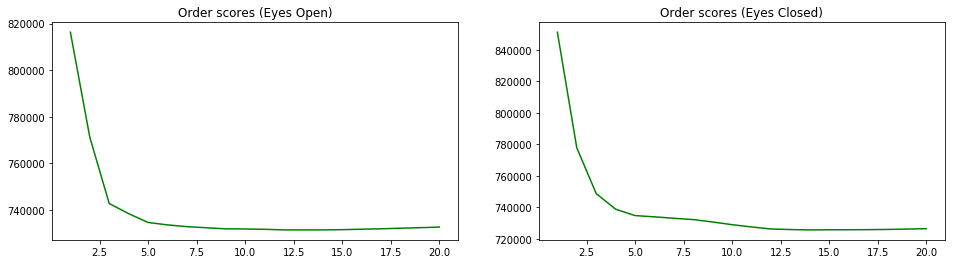

Best Order (Eyes Open): 13
Best Order (Eyes Closed): 13


In [65]:
# MVAR best model order determination

#getting the best order for the open state 
mv = cp.Mvar
# getting the best order for MVAR
# using Vieira-Morf algorithm        
max_model_order = 20
method = 'vm'
subset_best_order_open, subset_order_scores_open = mv.order_akaike(EO.signals, max_model_order, method)
subset_best_order_closed, subset_order_scores_closed = mv.order_akaike(EC.signals, max_model_order, method)

# find best model order using Vieira-Morf algorithm
fig, (axes_open, axes_closed) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=16, h=4)

axes_open.plot(1+np.arange(len(subset_order_scores_open)), subset_order_scores_open, 'g')
axes_open.set_title("Order scores (Eyes Open)")
axes_closed.plot(1+np.arange(len(subset_order_scores_closed)), subset_order_scores_closed, 'g')
axes_closed.set_title("Order scores (Eyes Closed)")
plt.show()

print("Best Order (Eyes Open):", subset_best_order_open)
print("Best Order (Eyes Closed):", subset_best_order_open)

In [35]:
# MVAR modeling, DFT and PDC estimators
sampling_frequency = 160.0
subset_cpdata_open = cp.Data(data=EO.signals, fs=sampling_frequency, chan_names=EO.labels)
subset_cpdata_closed = cp.Data(data=EC.signals, fs=sampling_frequency, chan_names=EC.labels)

dtf = cp.conn.DTF()
pdc = cp.conn.PDC()

In [40]:
dtf_estimates_open, pdc_estimates_open = get_connectivity_estimates(subset_data_open, EO.labels, 
                                                                    subset_best_order_open)
dtf_estimates_closed, pdc_estimates_closed = get_connectivity_estimates(subset_data_closed, subset_channel_names, 
                                                                        subset_best_order_closed)

C:\Users\azimedemtsvd\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


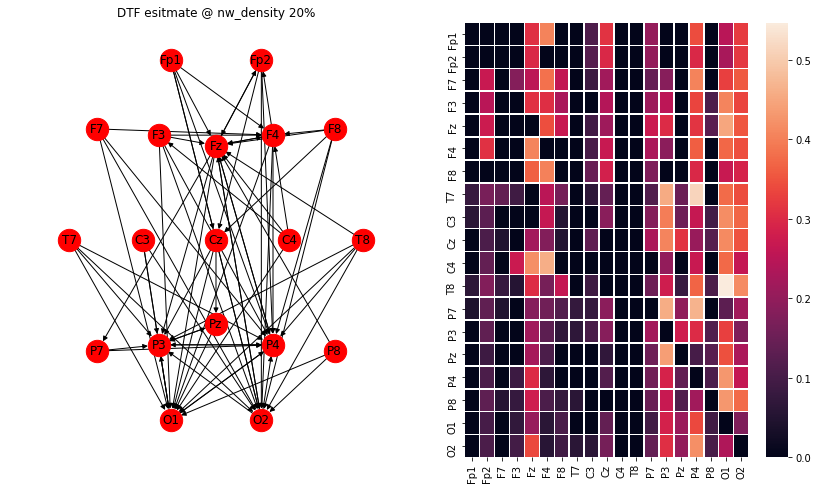

In [66]:
G_opened = draw_graph(dtf_estimates_open[relevant_frequency], subset_channel_names, locations,
           title = 'DTF esitmate @ nw_density 20%',
           network_density = 20, heatmap=True)

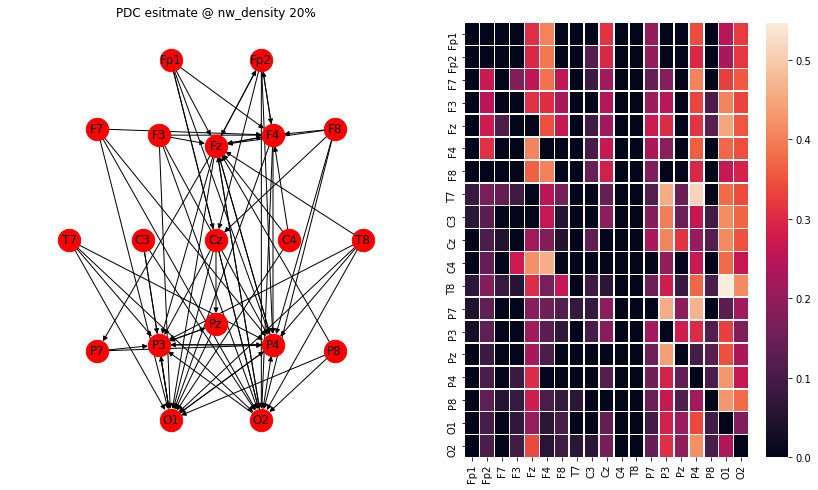

In [67]:
draw_graph(pdc_estimates_open[relevant_frequency], subset_channel_names, locations,
           title = 'PDC esitmate @ nw_density 20%',
           network_density = 20,
           heatmap=True
          )

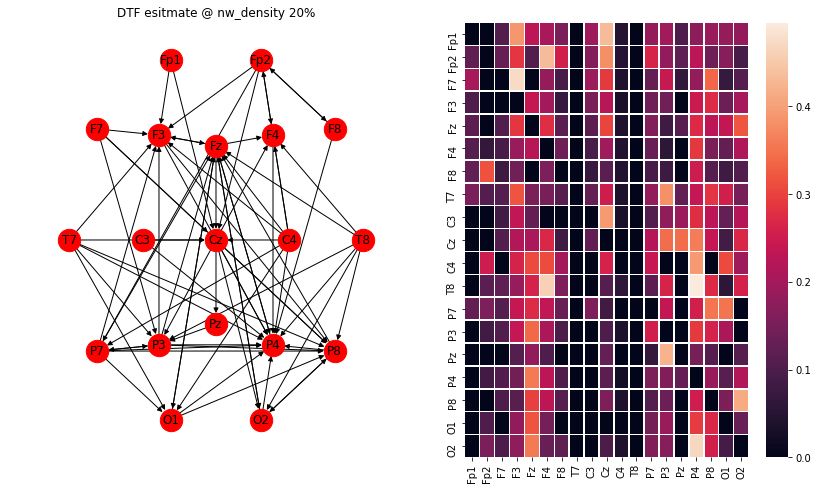

In [68]:
G_closed = draw_graph(dtf_estimates_closed[relevant_frequency], subset_channel_names, locations,
           title = 'DTF esitmate @ nw_density 20%',
           network_density = 20,
           heatmap=True
          )

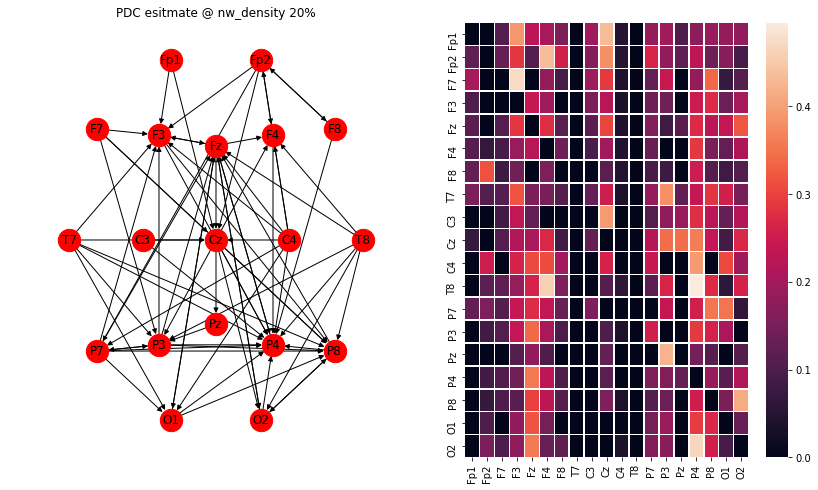

In [69]:
draw_graph(pdc_estimates_closed[relevant_frequency], subset_channel_names, locations,
           title = 'PDC esitmate @ nw_density 20%',
           network_density = 20,
           heatmap=True
          )

In [70]:
nx.write_weighted_edgelist(G_opened, path= "../Pickle/G_opend_1_4.nx")
nx.write_weighted_edgelist(G_closed, path="../Pickle/G_closd_1_4.nx")